신용카드 연체 가능성 예측 *https://dacon.io/competitions/official/236202/overview/description*

0. 라이브러리 불러오기
1. 데이터 불러오기
2. 데이터 시각화
3. 전처리
4. 모델링
    - RandomForestClassifier
    - catboost
    - Elastic Net

### 0. 라이브러리 불러오기

In [ ]:
import random
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(fname = 'nanum', name = 'nanum')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams['font.family'] = 'NanumGothic'

###       1. 데이터 불러오기

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

display(train.head(3))
display(test.head(3))

,ID,TARGET,성별,차량 소유 여부,부동산 소유 여부,자녀 수,연간 수입,수입 유형,최종 학력,결혼 여부,...,거주지 인구 비율,휴대전화 소유 여부,업무용 휴대전화 소유 여부,이메일 소유 여부,직업,가족 구성원 수,산업군,나이,근속연수,가입연수
0,TRAIN_00000,0,여성,1,1,2,18054000.0,연금수령자,고등학교 졸업,기혼,...,0.004960,1,0,0,Unknown,4.0,기타 1,39,1000,23.0
1,TRAIN_00001,0,남성,1,0,0,59472000.0,근로자,대학교 졸업 이상,기혼,...,0.018029,1,1,0,기술직,2.0,사업 1,45,4,16.0
2,TRAIN_00002,0,여성,0,1,0,29736000.0,근로자,고등학교 졸업,기혼,...,0.010500,1,1,0,단순 노동자,2.0,사업 0,32,3,9.0


,ID,성별,차량 소유 여부,부동산 소유 여부,자녀 수,연간 수입,수입 유형,최종 학력,결혼 여부,주거 형태,거주지 인구 비율,휴대전화 소유 여부,업무용 휴대전화 소유 여부,이메일 소유 여부,직업,가족 구성원 수,산업군,나이,근속연수,가입연수
0,TEST_00000,남성,0,0,2,37170000.0,근로자,대학교 중퇴,기혼,주택 / 아파트,0.006296,1,1,0,핵심 노동자,4.0,기타 0,27,2,8.0
1,TEST_00001,남성,0,0,0,47790000.0,근로자,대학교 졸업 이상,기혼,주택 / 아파트,0.004960,1,1,0,관리직,2.0,정부,40,8,11.0
2,TEST_00002,남성,1,1,1,37170000.0,공무원,고등학교 졸업,기혼,주택 / 아파트,0.026392,1,1,0,관리직,3.0,국가 안보,43,15,14.0


train.csv
- ID : 신용카드를 보유한 고객의 고유 ID
- TARGET : 고객의 신용카드 연체 여부 (0/1)
- 성별 (남성/여성)
- 차량 소유 여부 (0/1)
- 부동산 소유 여부 (0/1)
- 자녀 수 (0~19)
- 연간 수입 : 단위 원 (6,265,800~2,124,000,000)
- 수입 유형 (근로자/기타/연금수령자/공무원/실직자/학생/사업가)
- 최종 학력 (고등학교 졸업/대학교 졸업 이상/대학교 중퇴/저학력자)
- 결혼 여부 (기혼/미혼/사실혼/별거/사별)
- 주거 형태 (주택아파트/공공분양/아파트 임대/오피스텔)
- 거주지 인구 비율: 고객이 거주하는 지역 인근의 인구 비율 (0~1)
- 휴대전화 소유 여부 (0/1)
- 업무용 휴대폰 소유 여부 (0/1)
- 이메일 소유 여부 (0/1)
- 직업
- 가족 구성원 수 (1~20)
- 산업군 : 고객이 종사하는 직종의 산업군
- 나이 (21~69)
- 근속연수 (0~1000)
- 가입연수 (0~58)

In [ ]:
col = ['TARGET', '성별', '차량 소유 여부', '부동산 소유 여부', '수입 유형', '최종 학력', '결혼 여부', '주거 형태','휴대전화 소유 여부', '업무용 휴대전화 소유 여부', '이메일 소유 여부', '직업', '산업군']

for c in col:
    train[c] = train[c].astype('object')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              60000 non-null  object 
 1   TARGET          60000 non-null  object 
 2   성별              60000 non-null  object 
 3   차량 소유 여부        60000 non-null  object 
 4   부동산 소유 여부       60000 non-null  object 
 5   자녀 수            60000 non-null  int64  
 6   연간 수입           60000 non-null  float64
 7   수입 유형           60000 non-null  object 
 8   최종 학력           60000 non-null  object 
 9   결혼 여부           60000 non-null  object 
 10  주거 형태           60000 non-null  object 
 11  거주지 인구 비율       60000 non-null  float64
 12  휴대전화 소유 여부      60000 non-null  object 
 13  업무용 휴대전화 소유 여부  60000 non-null  object 
 14  이메일 소유 여부       60000 non-null  object 
 15  직업              60000 non-null  object 
 16  가족 구성원 수        60000 non-null  float64
 17  산업군             60000 non-null 

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
자녀 수,60000.0,4.120500e-01,7.239983e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
연간 수입,60000.0,3.983699e+07,2.472331e+07,6.265800e+06,2.655000e+07,3.504600e+07,4.779000e+07,2.124000e+09
거주지 인구 비율,60000.0,2.088044e-02,1.384969e-02,5.330000e-04,1.000600e-02,1.885000e-02,2.866300e-02,7.250800e-02
가족 구성원 수,60000.0,2.155767e+00,9.082128e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
나이,60000.0,4.402118e+01,1.185245e+01,2.100000e+01,3.400000e+01,4.300000e+01,5.400000e+01,6.900000e+01
근속연수,60000.0,1.929068e+02,3.882928e+02,0.000000e+00,2.000000e+00,6.000000e+00,1.600000e+01,1.000000e+03
가입연수,60000.0,1.327183e+01,9.727011e+00,0.000000e+00,5.000000e+00,1.200000e+01,2.000000e+01,5.800000e+01


In [ ]:
train.describe(include="object").T

,count,unique,top,freq
ID,60000,60000,TRAIN_00000,1
TARGET,60000,2,0,53572
성별,60000,3,여성,39734
차량 소유 여부,60000,2,0,39749
부동산 소유 여부,60000,2,1,42518
수입 유형,60000,7,근로자,30693
최종 학력,60000,4,고등학교 졸업,42910
결혼 여부,60000,5,기혼,38795
주거 형태,60000,4,주택 / 아파트,56042
휴대전화 소유 여부,60000,2,1,59999


In [ ]:
train.isnull().sum()

ID                0
TARGET            0
성별                0
차량 소유 여부          0
부동산 소유 여부         0
자녀 수              0
연간 수입             0
수입 유형             0
최종 학력             0
결혼 여부             0
주거 형태             0
거주지 인구 비율         0
휴대전화 소유 여부        0
업무용 휴대전화 소유 여부    0
이메일 소유 여부         0
직업                0
가족 구성원 수          0
산업군               0
나이                0
근속연수              0
가입연수              0
dtype: int64

### 2. 데이터 시각화

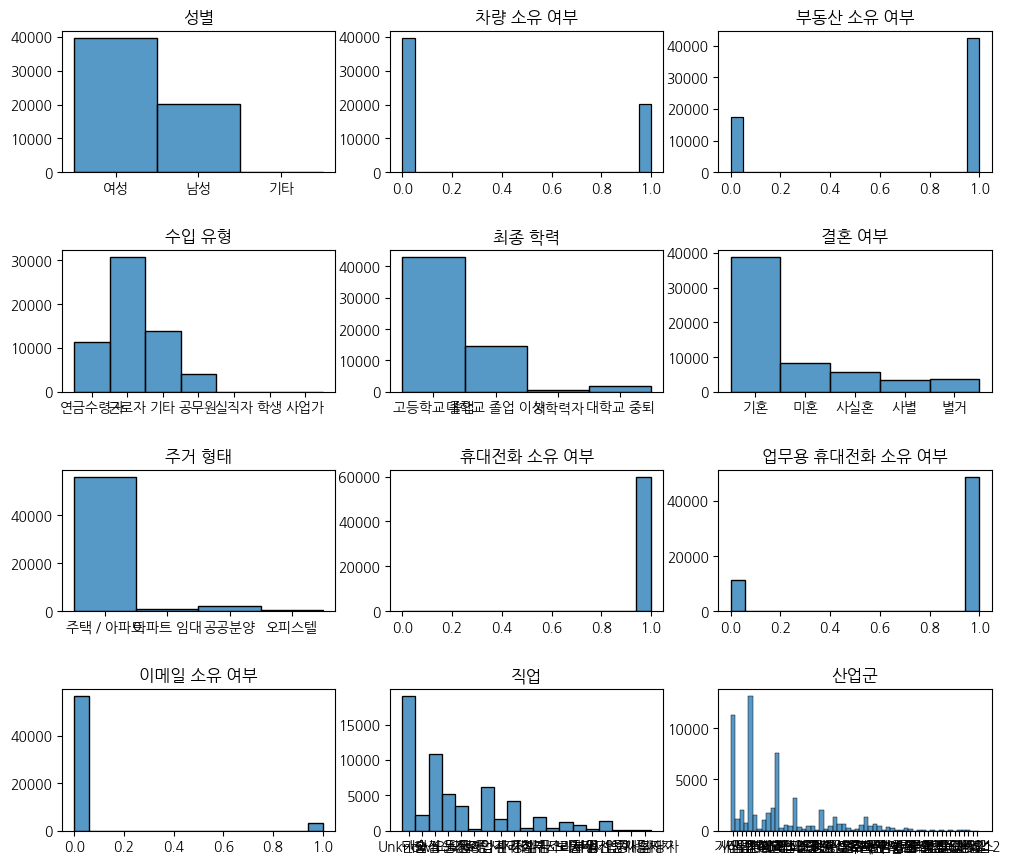

In [ ]:
col = ['성별', '차량 소유 여부', '부동산 소유 여부', '수입 유형', '최종 학력', '결혼 여부', '주거 형태','휴대전화 소유 여부', '업무용 휴대전화 소유 여부', '이메일 소유 여부', '직업', '산업군']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.histplot(train[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

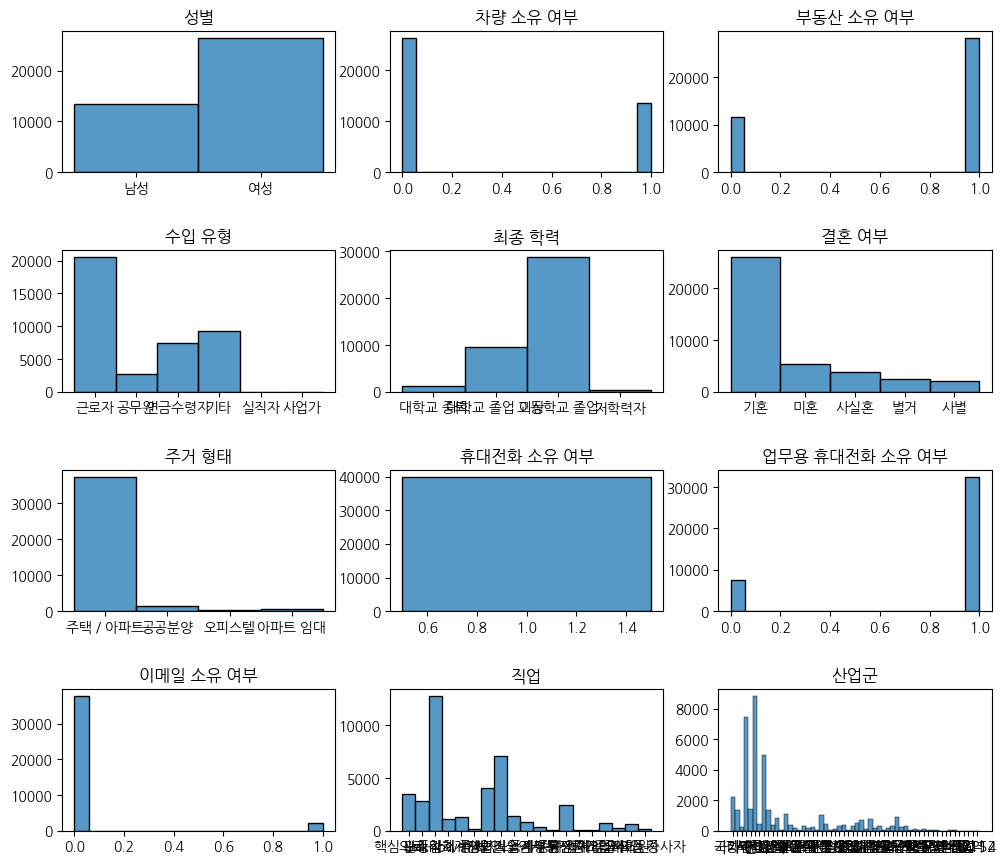

In [ ]:
col = ['성별', '차량 소유 여부', '부동산 소유 여부', '수입 유형', '최종 학력', '결혼 여부', '주거 형태','휴대전화 소유 여부', '업무용 휴대전화 소유 여부', '이메일 소유 여부', '직업', '산업군']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.histplot(test[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


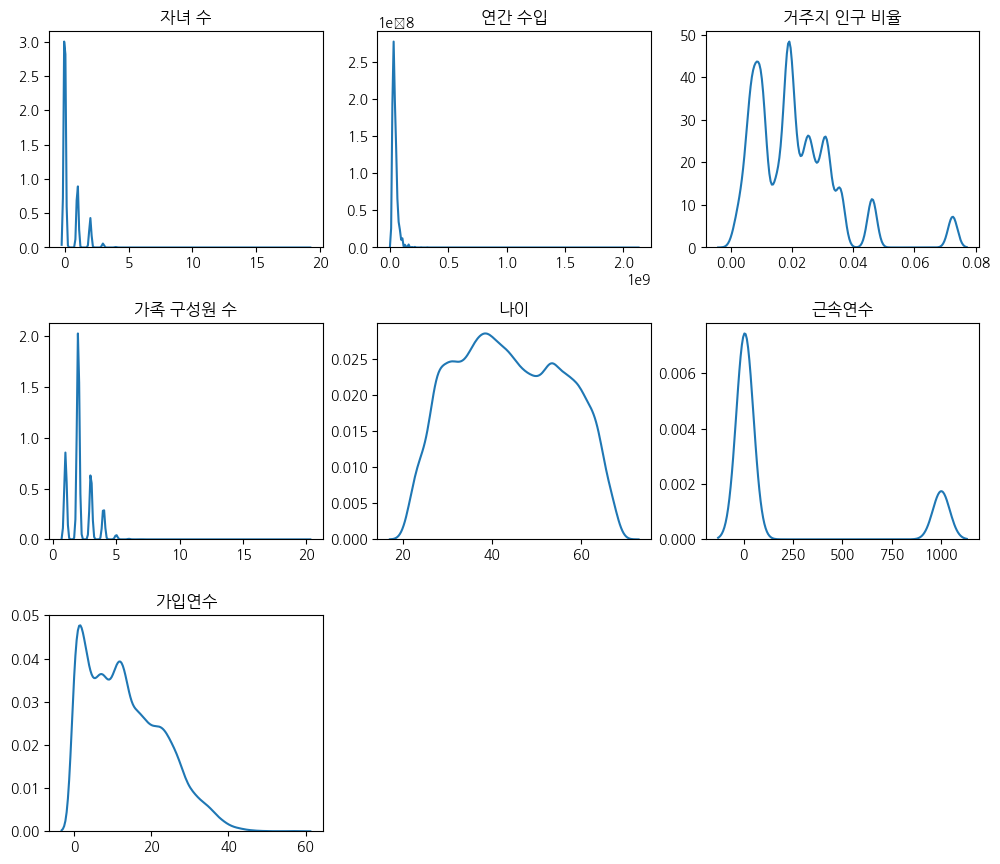

In [ ]:
col = ['자녀 수', '연간 수입', '거주지 인구 비율', '가족 구성원 수', '나이', '근속연수', '가입연수']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1, )
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.title(col[i])
    sns.kdeplot(train[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

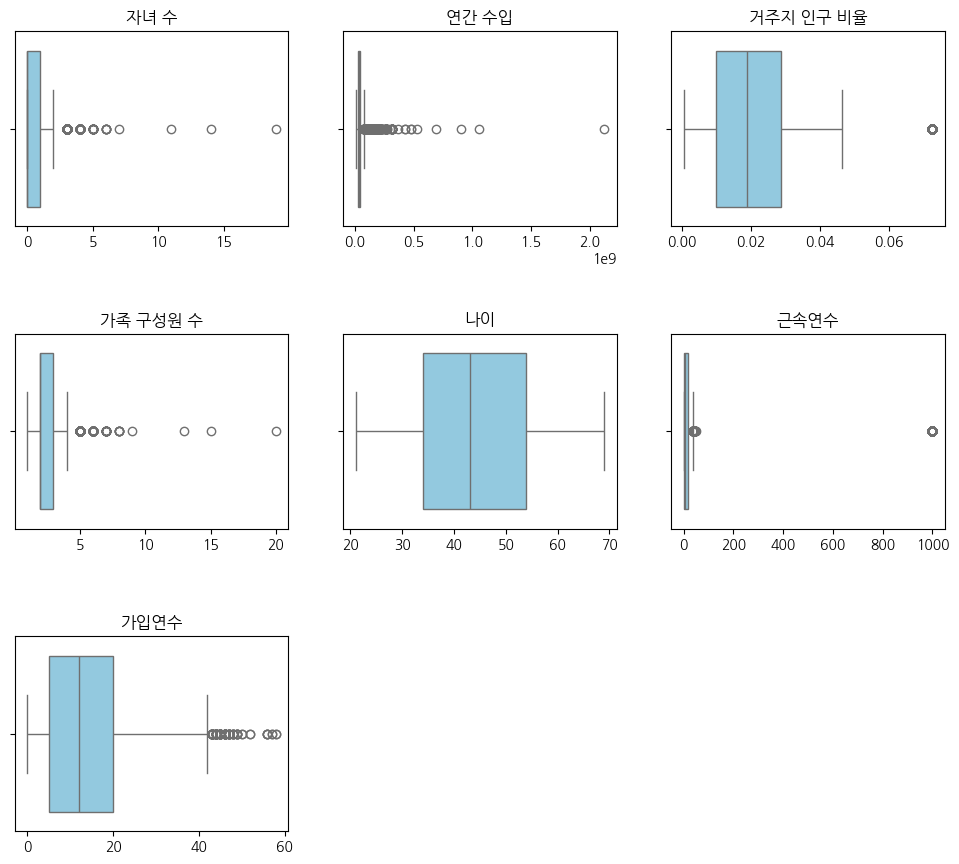

In [ ]:
col = ['자녀 수', '연간 수입', '거주지 인구 비율', '가족 구성원 수', '나이', '근속연수', '가입연수']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.boxplot(x=train[col[i]], color='skyblue')
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

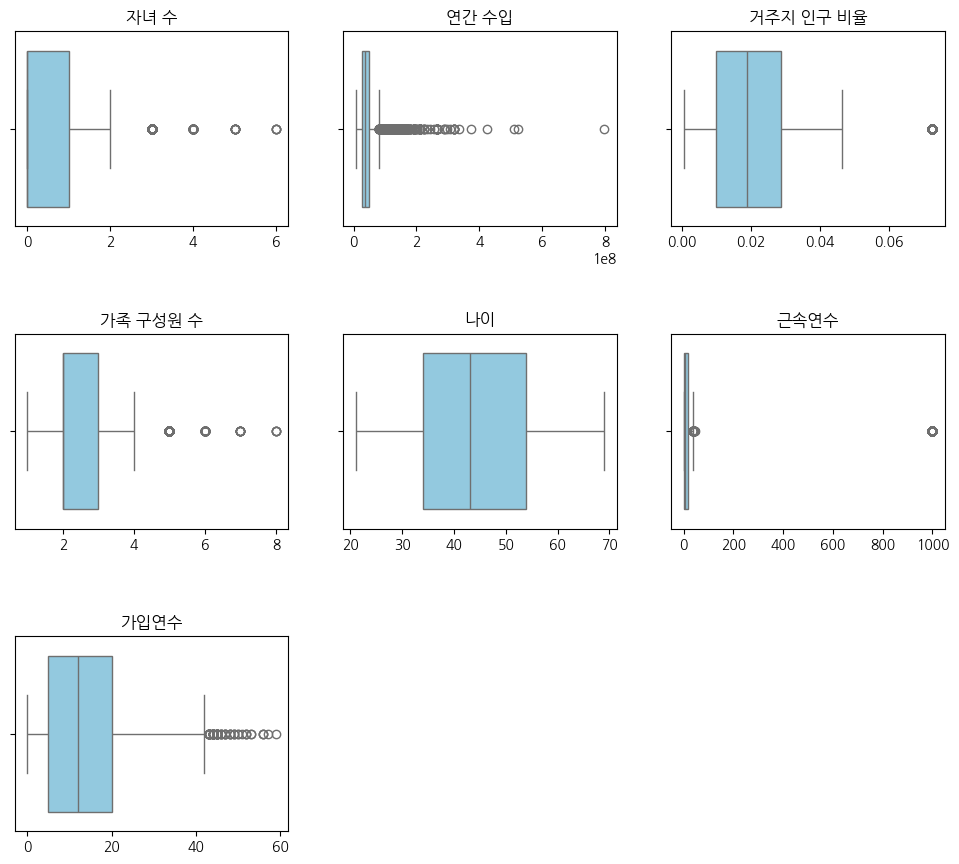

In [ ]:
col = ['자녀 수', '연간 수입', '거주지 인구 비율', '가족 구성원 수', '나이', '근속연수', '가입연수']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.boxplot(x=test[col[i]], color='skyblue')
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

### 3. 전처리

In [ ]:
# train = train[train['자녀 수'] < 6]
# train = train[train['연간 수입'] < 8e+08]

In [ ]:
# train['근속연수'] = train['근속연수'].apply(lambda x: round(train['근속연수'][train['근속연수'] < 100].mean()) if x > 100 else x)
# 기타 1 = 연금수령자 + 실직자 > 근속 연수 1000

In [ ]:
train = train[train['성별'] != '기타']
train = train.drop('휴대전화 소유 여부', axis=1)

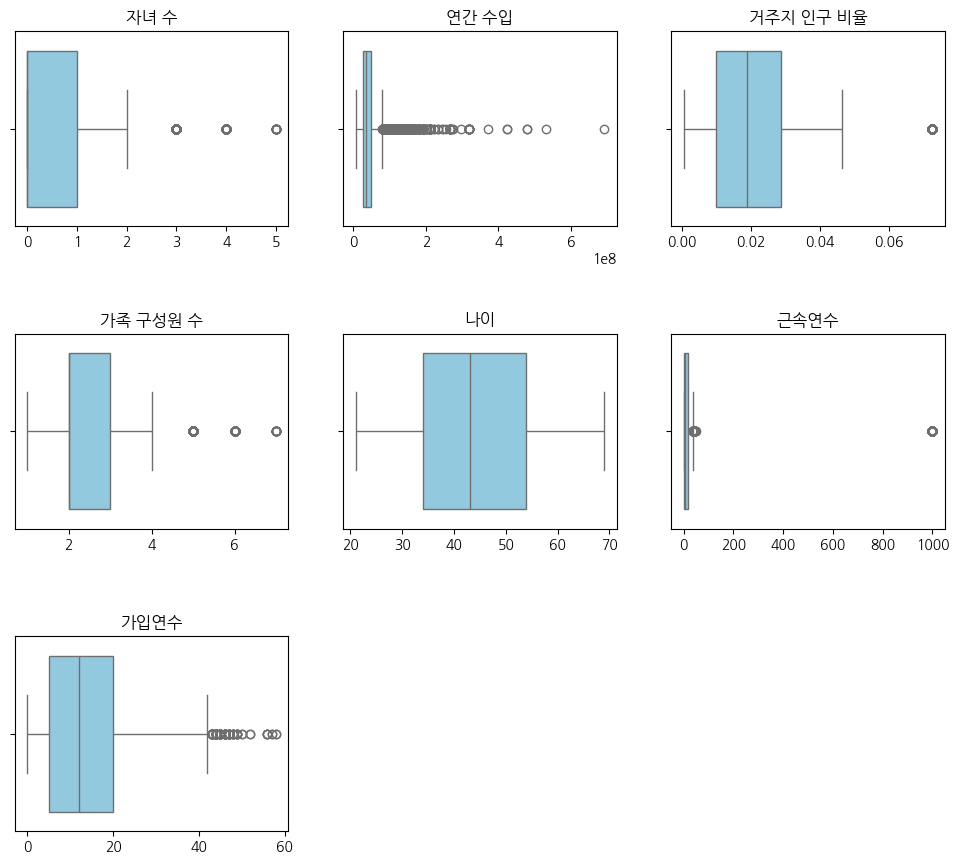

In [ ]:
col = ['자녀 수', '연간 수입', '거주지 인구 비율', '가족 구성원 수', '나이', '근속연수', '가입연수']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.boxplot(x=train[col[i]], color='skyblue')
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

<ipython-input-160-84fff67f4910>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = df_corr.corr(), annot=True, cmap='Blues', fmt = '.2f', linewidths=.5)
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


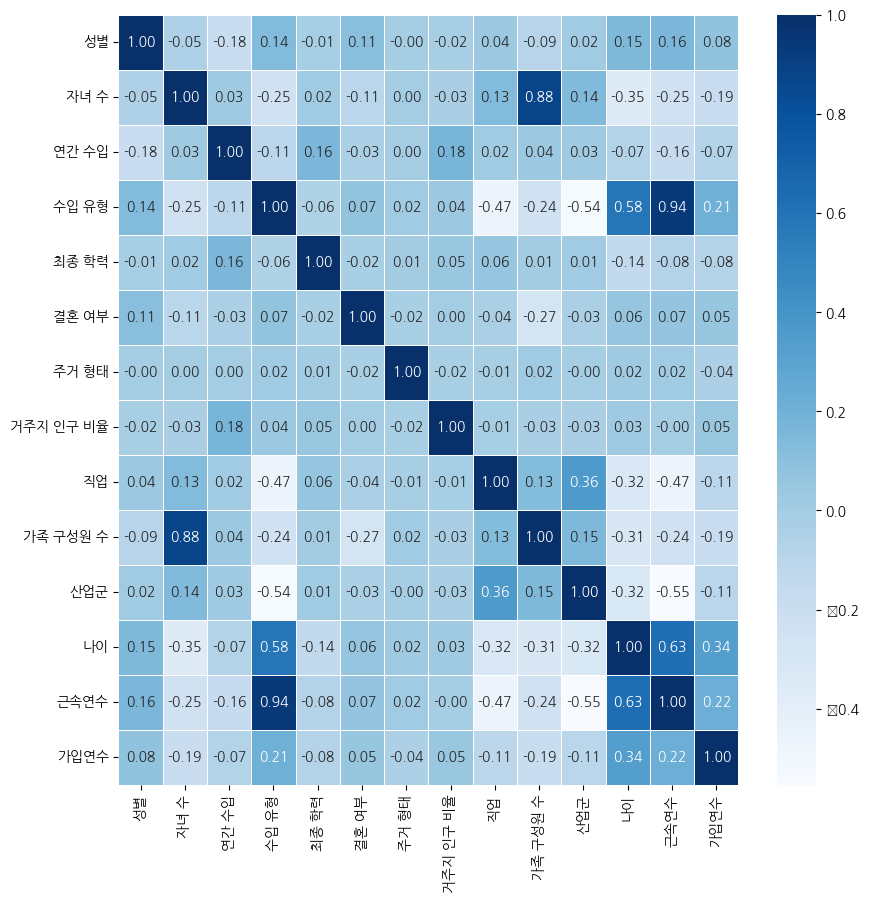

In [ ]:
df_corr = train.drop(['ID'], axis=1)

plt.figure(figsize=(10,10))
sns.heatmap(data = df_corr.corr(), annot=True, cmap='Blues', fmt = '.2f', linewidths=.5)

In [ ]:
train.to_csv('new_train.csv', index=False)

In [ ]:
# new_train = pd.read_csv('new_train.csv')

### 4. 모델링

In [ ]:
train_x = train.drop(columns=['ID', 'TARGET'])
train_y = train['TARGET']

test_x = test.drop(columns=['ID', '휴대전화 소유 여부'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['성별', '수입 유형', '최종 학력', '결혼 여부', '주거 형태', '직업', '산업군'] # , '업무용 휴대전화 소유 여부', '차량 소유 여부', '부동산 소유 여부', '이메일 소유 여부'

for i in categorical_features:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])

    for case in np.unique(test_x[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_x[i]=le.transform(test_x[i])

display(train_x.head(3))
display(test_x.head(3))

,성별,차량 소유 여부,부동산 소유 여부,자녀 수,연간 수입,수입 유형,최종 학력,결혼 여부,주거 형태,거주지 인구 비율,업무용 휴대전화 소유 여부,이메일 소유 여부,직업,가족 구성원 수,산업군,나이,근속연수,가입연수
0,1,1,1,2,18054000.0,5,0,0,3,0.004960,0,0,1,4.0,6,39,1000,23.0
1,0,1,0,0,59472000.0,1,1,0,3,0.018029,1,0,4,2.0,24,45,4,16.0
2,1,0,1,0,29736000.0,1,0,0,3,0.010500,1,0,5,2.0,23,32,3,9.0


,성별,차량 소유 여부,부동산 소유 여부,자녀 수,연간 수입,수입 유형,최종 학력,결혼 여부,주거 형태,거주지 인구 비율,업무용 휴대전화 소유 여부,이메일 소유 여부,직업,가족 구성원 수,산업군,나이,근속연수,가입연수
0,0,0,0,2,37170000.0,1,2,0,3,0.006296,1,0,17,4.0,5,27,2,8.0
1,0,0,0,0,47790000.0,1,1,0,3,0.004960,1,0,3,2.0,49,40,8,11.0
2,0,1,1,1,37170000.0,0,0,0,3,0.026392,1,0,3,3.0,3,43,15,14.0


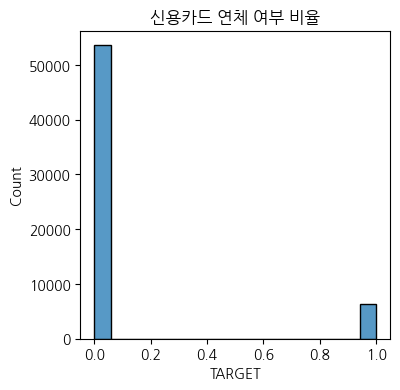

In [ ]:
plt.subplots(figsize = (4,4))

sns.histplot(train, x='TARGET')
plt.title('신용카드 연체 여부 비율')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
train_x_oversampled, train_y_oversampled = oversampler.fit_resample(train_x, train_y)

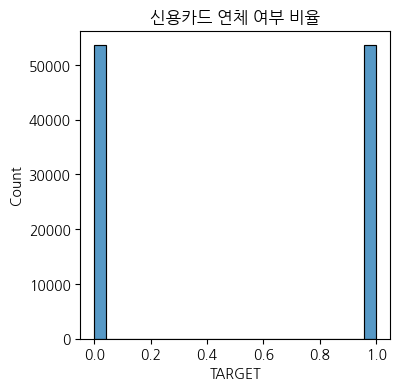

In [ ]:
plt.subplots(figsize = (4,4))

sns.histplot(train_y_oversampled)
plt.title('신용카드 연체 여부 비율')
plt.show()

#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(train_x_oversampled, train_y_oversampled)

RandomForestClassifier(random_state=42)

In [ ]:
pred_probability = model.predict_proba(test_x)

display(model.classes_)
display(pred_probability)

array([0, 1])

array([[0.78, 0.22],
       [0.93, 0.07],
       [0.98, 0.02],
       ...,
       [0.85, 0.15],
       [0.96, 0.04],
       [0.9 , 0.1 ]])

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

baseline_submission = sample_submission.copy()
baseline_submission['TARGET'] = pred_probability[:,1]
baseline_submission

,ID,TARGET
0,TEST_00000,0.22
1,TEST_00001,0.07
2,TEST_00002,0.02
3,TEST_00003,0.08
4,TEST_00004,0.34
...,...,...
39995,TEST_39995,0.03
39996,TEST_39996,0.12
39997,TEST_39997,0.15
39998,TEST_39998,0.04


In [ ]:
baseline_submission.to_csv('baseline_submission.csv', index=False)

* n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
* max_features: 각 트리에서 분할에 사용할 최대 특성의 수
* max_depth: 각 트리의 최대 깊이
* min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수
* min_samples_leaf: 리프 노드가 되기 위해 필요한 최소 샘플 수

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [0.5, 1],
    'max_samples': [.5, .9]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(train_x, train_y)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001, 'n_estimators': 50}
Best Accuracy: 0.8928648817957052


In [ ]:
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

best_rf_model.fit(train_x, train_y)

predictions = best_rf_model.predict_proba(test_x)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

RandomForestClassifier_submission = sample_submission.copy()
RandomForestClassifier_submission['TARGET'] = predictions[:,1]

In [ ]:
RandomForestClassifier_submission.to_csv('RandomForestClassifier_submission.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(train_x, train_y, test_size=0.3)
train_data_x.reset_index(inplace=True)
val_data_x.reset_index(inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_md1 = RandomForestClassifier(max_depth = 1)
model_md10 = RandomForestClassifier(max_depth = 10)
model_md20 = RandomForestClassifier(max_depth = 20)

model_md1.fit(train_data_x, train_data_y)
model_md10.fit(train_data_x, train_data_y)
model_md20.fit(train_data_x, train_data_y)

pred_md1 = model_md1.predict(val_data_x)
pred_md10 = model_md10.predict(val_data_x)
pred_md20 = model_md20.predict(val_data_x)

print('RF max_depth = 1', round(metrics.accuracy_score(val_data_y, pred_md1),3))
print('RF max_depth = 10', round(metrics.accuracy_score(val_data_y, pred_md10),3))
print('RF max_depth = 20', round(metrics.accuracy_score(val_data_y, pred_md20),3))

RF max_depth = 1 0.892
RF max_depth = 10 0.892
RF max_depth = 20 0.892


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_ne1 = RandomForestClassifier(n_estimators = 1)
model_ne50 = RandomForestClassifier(n_estimators = 50)
model_ne100 = RandomForestClassifier(n_estimators = 100)

model_ne1.fit(train_data_x, train_data_y)
model_ne50.fit(train_data_x, train_data_y)
model_ne100.fit(train_data_x, train_data_y)

pred_ne1 = model_ne1.predict(val_data_x)
pred_ne50 = model_ne50.predict(val_data_x)
pred_ne100 = model_ne100.predict(val_data_x)

print('RF n_estimators = 1', round(metrics.accuracy_score(val_data_y, pred_ne1),3))
print('RF n_estimators = 50', round(metrics.accuracy_score(val_data_y, pred_ne50),3))
print('RF n_estimators = 100', round(metrics.accuracy_score(val_data_y, pred_ne100),3))

RF n_estimators = 1 0.802
RF n_estimators = 50 0.892
RF n_estimators = 100 0.892


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(10, 50),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)

random_search.fit(train_x, train_y)

print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 18}
Best Accuracy: 0.8928982151290386


In [ ]:
best_rf_model = RandomForestClassifier(**random_search.best_params_, random_state=42)

best_rf_model.fit(train_x, train_y)

predictions = best_rf_model.predict_proba(test_x)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

RandomForestClassifier_submission = sample_submission.copy()
RandomForestClassifier_submission['TARGET'] = predictions[:,1]
RandomForestClassifier_submission

,ID,TARGET
0,TEST_00000,0.217819
1,TEST_00001,0.134178
2,TEST_00002,0.062557
3,TEST_00003,0.094980
4,TEST_00004,0.195274
...,...,...
39995,TEST_39995,0.010798
39996,TEST_39996,0.091407
39997,TEST_39997,0.059542
39998,TEST_39998,0.020165


In [ ]:
RandomForestClassifier_submission.to_csv('RandomForestClassifier2_submission.csv', index=False)

#### catboost

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['성별', '수입 유형', '최종 학력', '결혼 여부', '주거 형태', '직업', '산업군']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

    for case in np.unique(test[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test[i]=le.transform(test[i])


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = train.drop(['ID', 'TARGET'], axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

0:	learn: 0.3085478	test: 0.3087975	best: 0.3087975 (0)	total: 25.4ms	remaining: 25.4s
100:	learn: 0.3010610	test: 0.3052695	best: 0.3051486 (61)	total: 1.99s	remaining: 17.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3051486499
bestIteration = 61

Shrink model to first 62 iterations.


In [ ]:
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost.csv', index=False)

y_val_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)

Validation Set RMSE: 0.3051486499186477


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = train.drop(['ID', 'TARGET'], axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='CrossEntropy', random_state=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

0:	learn: 0.6143445	test: 0.6145571	best: 0.6145571 (0)	total: 16.5ms	remaining: 16.5s
100:	learn: 0.3164681	test: 0.3280669	best: 0.3279614 (78)	total: 3.43s	remaining: 30.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3279613879
bestIteration = 78

Shrink model to first 79 iterations.


In [ ]:
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost.csv', index=False)

y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[10712,     1],
       [ 1287,     0]])

* n_estimators(iterations): 구축할 수 있는 최대 트리 수, 기본값: 1000
* depth:트리의 깊이 (1, 16) 기본값: 6
* learning rate: 각 훈련 예제 배치를 살펴본 후 모델 가중치가 업데이트되는 비율 (0.0, 1.0) 기본값: 0.009.
* min_child_samples(min_data_in_leaf): 최소 훈련 샘플 수, 기본값 1
* grow_policy: 트리 성장 정책. 거대한 트리 빌드 방법을 정의 ("SymmetricTree", "Depthwise"  "Lossguide")

    *https://catboost.ai/en/docs/references/training-parameters/*

In [ ]:
import catboost
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = train.drop(['ID', 'TARGET'], axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_cat = catboost.CatBoostRegressor(eval_metric='R2')

param_grid = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

model_cat.randomized_search(param_grid, X_train, y_train, cv=3, n_iter=10, verbose=1)
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=10, early_stopping_rounds=50)

0:	learn: -0.1040146	test: -0.1083000	best: -0.1083000 (0)	total: 54ms	remaining: 6.42s
1:	learn: -0.0906062	test: -0.0949846	best: -0.0949846 (1)	total: 60.8ms	remaining: 3.59s
2:	learn: -0.0793513	test: -0.0838642	best: -0.0838642 (2)	total: 65.8ms	remaining: 2.56s
3:	learn: -0.0691686	test: -0.0736765	best: -0.0736765 (3)	total: 71ms	remaining: 2.06s
4:	learn: -0.0598969	test: -0.0641201	best: -0.0641201 (4)	total: 75.9ms	remaining: 1.75s
5:	learn: -0.0516557	test: -0.0559583	best: -0.0559583 (5)	total: 80.9ms	remaining: 1.54s
6:	learn: -0.0442734	test: -0.0484979	best: -0.0484979 (6)	total: 86ms	remaining: 1.39s
7:	learn: -0.0375237	test: -0.0416035	best: -0.0416035 (7)	total: 91.9ms	remaining: 1.29s
8:	learn: -0.0316005	test: -0.0357474	best: -0.0357474 (8)	total: 97.5ms	remaining: 1.2s
9:	learn: -0.0261788	test: -0.0304075	best: -0.0304075 (9)	total: 103ms	remaining: 1.13s
10:	learn: -0.0212435	test: -0.0254592	best: -0.0254592 (10)	total: 113ms	remaining: 1.12s
11:	learn: -0.017

In [ ]:
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model_cat.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost.csv', index=False)

y_val_pred = model_cat.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)


Validation Set RMSE: 0.3050287875725899


In [ ]:
model_cat.fit(X, y, verbose=10, early_stopping_rounds=50)
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model_cat.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost.csv', index=False)

0:	learn: 0.0017027	total: 7.92ms	remaining: 2.28s
10:	learn: 0.0122253	total: 71.6ms	remaining: 1.81s
20:	learn: 0.0177369	total: 129ms	remaining: 1.65s
30:	learn: 0.0205004	total: 192ms	remaining: 1.6s
40:	learn: 0.0227832	total: 251ms	remaining: 1.52s
50:	learn: 0.0243971	total: 310ms	remaining: 1.45s
60:	learn: 0.0255604	total: 368ms	remaining: 1.38s
70:	learn: 0.0265165	total: 434ms	remaining: 1.33s
80:	learn: 0.0272459	total: 495ms	remaining: 1.27s
90:	learn: 0.0279440	total: 558ms	remaining: 1.21s
100:	learn: 0.0284518	total: 619ms	remaining: 1.15s
110:	learn: 0.0289116	total: 693ms	remaining: 1.11s
120:	learn: 0.0292688	total: 757ms	remaining: 1.05s
130:	learn: 0.0295985	total: 817ms	remaining: 986ms
140:	learn: 0.0301096	total: 877ms	remaining: 921ms
150:	learn: 0.0303949	total: 944ms	remaining: 863ms
160:	learn: 0.0307313	total: 1s	remaining: 799ms
170:	learn: 0.0310154	total: 1.06s	remaining: 735ms
180:	learn: 0.0312728	total: 1.12s	remaining: 669ms
190:	learn: 0.0316907	tot

In [ ]:
import catboost
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = train.drop(['ID', 'TARGET'], axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_cat = catboost.CatBoostClassifier(eval_metric='CrossEntropy')

param_grid = {
    'learning_rate': [0.03, 0.06],
    'depth':[3, 6, 9],
    'l2_leaf_reg': [2, 3, 4],
    'boosting_type': ['Ordered', 'Plain']
}

model_cat.randomized_search(param_grid, X_train, y_train, cv=3, n_iter=10, verbose=1)
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=10, early_stopping_rounds=50)

In [ ]:
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model_cat.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost2.csv', index=False)

y_val_pred = model_cat.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[10712,     1],
       [ 1287,     0]])

In [ ]:
model_cat.fit(X, y, verbose=10, early_stopping_rounds=50)
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)
predictions = model_cat.predict(X_test)

submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_catboost.csv', index=False)

0:	learn: 0.0017027	total: 7.92ms	remaining: 2.28s
10:	learn: 0.0122253	total: 71.6ms	remaining: 1.81s
20:	learn: 0.0177369	total: 129ms	remaining: 1.65s
30:	learn: 0.0205004	total: 192ms	remaining: 1.6s
40:	learn: 0.0227832	total: 251ms	remaining: 1.52s
50:	learn: 0.0243971	total: 310ms	remaining: 1.45s
60:	learn: 0.0255604	total: 368ms	remaining: 1.38s
70:	learn: 0.0265165	total: 434ms	remaining: 1.33s
80:	learn: 0.0272459	total: 495ms	remaining: 1.27s
90:	learn: 0.0279440	total: 558ms	remaining: 1.21s
100:	learn: 0.0284518	total: 619ms	remaining: 1.15s
110:	learn: 0.0289116	total: 693ms	remaining: 1.11s
120:	learn: 0.0292688	total: 757ms	remaining: 1.05s
130:	learn: 0.0295985	total: 817ms	remaining: 986ms
140:	learn: 0.0301096	total: 877ms	remaining: 921ms
150:	learn: 0.0303949	total: 944ms	remaining: 863ms
160:	learn: 0.0307313	total: 1s	remaining: 799ms
170:	learn: 0.0310154	total: 1.06s	remaining: 735ms
180:	learn: 0.0312728	total: 1.12s	remaining: 669ms
190:	learn: 0.0316907	tot

#### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

X = train_x_oversampled.drop(['휴대전화 소유 여부'], axis=1)
y = train['TARGET']
X_test = test.drop(['ID', '휴대전화 소유 여부'], axis=1)

elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5)

elastic_net.fit(X, y)

predictions = elastic_net.predict(X_test)

In [ ]:
submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_Elastic_Net_2.csv', index=False)

* max_iter: 최대 반복 횟수, 기본값 1000
* alpha: 페널티 조건을 곱하는 상수, 기본값 1.0
* l1_ratio: 0(L2 penalty) ~ 1(L1 penalty)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

elasticnet = ElasticNet()

parameters = {"max_iter": [1, 5, 10],
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            "l1_ratio": np.arange(0.0, 1.0, 0.1)}

elasticnet_reg = RandomizedSearchCV(elasticnet, parameters, scoring='r2',cv=5)
elasticnet_reg.fit(X, y)
print(elasticnet_reg.best_params_)
print(elasticnet_reg.best_score_)

In [ ]:
predictions = elasticnet_reg.predict(X_test)
submission = pd.DataFrame({'ID': test['ID'], 'TARGET': predictions})
submission.to_csv('submission_Elastic_Net_3.csv', index=False)

In [ ]:
elasticnet_reg.predict(X_test)

array([0.16357422, 0.14227098, 0.13597879, ..., 0.09903736, 0.02658192,
       0.10266618])